In [1]:
import datetime
import os
import random
from math import ceil

import keras
import plotly.io
import plotly.express as px
import polars as pl
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

random.seed(3)
tf.random.set_seed(3)

plotly.io.templates.default = "plotly_dark"

tf.config.list_physical_devices()

2024-05-10 22:02:48.038668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.15.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
# TODO After having trained a model, plot a heatmap store_nbr vs. family of loss values

# TODO After selecting the best model for each key, retrain the model on the corresponding keys only.
# TODO This could be better as the model will only be used on those keys
# TODO -> need a large enough number of keys per model (which is a good thing anyway)

In [3]:
INPUT_DIR = os.path.abspath("input")  # directory with inputs from the competition

# TODO use 'steps' instead of 'length' for length of time sequences?
TARGET_LENGTH = 16  # length of the target sequences

METADATA_VARS = 3  # number of metadata variables
TIMESTEPS = 800  # number of timesteps to use in training

# training hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 64

BUFFER_SIZE = 1_000

# the Kaggle competition uses Root Mean Squared Logarithmic Error
LOSS = keras.losses.MeanSquaredLogarithmicError()

# DATA PREPARATION

In [4]:
# NOTE This class is very unnecessay but it helps for type hints


class Key:
    def __init__(self, store_nbr: int, family: str):
        self.store_nbr = store_nbr
        self.family = family

    def __str__(self):
        return str((self.store_nbr, self.family))

    def __key(self):
        return (self.store_nbr, self.family)

    def __eq__(self, other):
        if isinstance(other, Key):
            return self.__key() == other.__key()
        return NotImplemented

    def __hash__(self):
        return hash(self.__key())

In [55]:
def read_dataframes(
    timesteps: int, include_target: bool
) -> tuple[dict[Key, pl.DataFrame], pl.DataFrame]:
    # read additional timesteps for either target or test set
    timedelta = datetime.timedelta(timesteps + TARGET_LENGTH)

    train_df = (
        pl.read_csv(os.path.join(INPUT_DIR, "train.csv"), try_parse_dates=True)
        .filter(pl.col("date") > pl.col("date").max() - timedelta)
        .drop("id")
    )

    if include_target:
        target_df = (
            pl.read_csv(os.path.join(INPUT_DIR, "test.csv"), try_parse_dates=True)
            .with_columns(pl.lit(None).alias("sales"))
            .select(train_df.columns)
        )

        train_df = pl.concat([train_df, target_df], how="vertical")

    oil_df = pl.read_csv(os.path.join(INPUT_DIR, "oil.csv"), try_parse_dates=True)
    oil_df = (
        oil_df.select(pl.date_range(pl.col("date").min(), pl.col("date").max(), "1d"))
        .join(oil_df, on="date", how="outer")
        .drop("date_right")
        .interpolate()
        .fill_null(strategy="backward")
    )

    dfs = train_df.partition_by(
        ["store_nbr", "family"], include_key=False, as_dict=True
    )

    date_range = next(iter(dfs.values())).select(
        pl.date_range(pl.col("date").min(), pl.col("date").max(), "1d")
    )

    for key, df in dfs.items():
        dfs[key] = (
            df.join(date_range, on="date", how="outer")
            .drop("date_right")
            .interpolate()
            .fill_null(strategy="backward")
            .join(oil_df, on="date", how="inner")
            .with_columns(weekday=pl.col("date").dt.weekday())
            .drop("date")
            .cast(pl.Float32)
        )

    return dfs, date_range

In [64]:
class KeysDataFrame:
    def __init__(self, timesteps: int, include_target: bool):
        dfs, date = read_dataframes(timesteps, include_target)  # TODO class method?

        # make a tensor with dims = (key, time, feature) containing all the data
        self._data = tf.stack([tf.constant(df) for df in dfs.values()], axis=0)
        self._key_index = {Key(*key): ind for ind, key in enumerate(dfs.keys())}  # type: ignore

        # store dataframe info to rebuild dataframes from tensor
        _df = next(iter(dfs.values()))
        self._columns = _df.columns
        self._date = date["date"]

        self.timesteps = timesteps

    def get_keys_data(self, keys: list[Key]) -> tf.Tensor:
        indices = [self._key_index[key] for key in keys]
        return tf.gather(self._data, indices=indices, axis=0)

    def __getitem__(self, key: Key) -> pl.DataFrame:
        data = tf.squeeze(tf.gather(self._data, self._key_index[key], axis=0))
        df = pl.DataFrame(data.numpy(), schema=self._columns)

        return df.insert_column(0, self._date)

    @property
    def keys(self):
        return list(self._key_index.keys())

In [65]:
kdf = KeysDataFrame(TIMESTEPS, False)

---

## Dataset creation

In [9]:
@tf.function
def _split_batch_window(window_batch: tf.Tensor):
    """Splits a batch of window into a batch of (inputs, target) pairs."""

    x_vars, y_vars = tf.split(window_batch, [-1, TARGET_LENGTH], axis=1)  # type: ignore

    # x_sale, x_meta = tf.split(x_vars, [1, -1], axis=-1)  # type: ignore
    y_sale, y_meta = tf.split(y_vars, [1, -1], axis=-1)  # type: ignore

    return (x_vars, y_meta), y_sale

In [10]:
class KeysDataset:
    def __init__(
        self,
        kdf: KeysDataFrame,
        input_length: int,
        keys: list[Key],
        train_ratio: float = 0.8,
    ):
        self.window_length = input_length + TARGET_LENGTH

        # split the total number of windows according to the ratio
        total_windows = kdf.timesteps - 2 * self.window_length + 2
        train_windows = int(total_windows * train_ratio)
        valid_windows = total_windows - train_windows

        # compute the number of timesteps corresponding to the number of training windows
        train_timesteps = train_windows + self.window_length - 1

        data = kdf.get_keys_data(keys)  # get the data for the selected keys
        data = tf.transpose(data, perm=[1, 0, 2])  # dims = (time, key, feature)

        train_data, valid_data = tf.split(data, [train_timesteps, -1], axis=0)  # type: ignore

        self.train = self._make_dataset(train_data)
        self.valid = self._make_dataset(valid_data)

        # compute the number of batches in each dataset (for self.length)
        self.train_batches = ceil(train_windows * len(keys) / BATCH_SIZE)
        self.valid_batches = ceil(valid_windows * len(keys) / BATCH_SIZE)

    def _make_dataset(self, data: tf.Tensor) -> tf.data.Dataset:
        ds = tf.data.Dataset.from_tensor_slices(data)  # spec = (keys, features)

        # window the time dimension -> spec = (window_length, keys, features)
        ds = ds.window(size=self.window_length, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda window: window.batch(self.window_length))

        # -> spec = (keys, window_length, features)
        ds = ds.map(lambda xs: tf.transpose(xs, perm=[1, 0, 2]))

        # split the key dimension into tensors -> spec = (window_length, features)
        ds = ds.flat_map(tf.data.Dataset.from_tensor_slices)

        return (
            ds.shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(_split_batch_window, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
        )

    # TODO return only train_batches? if no need for valid_batches
    @property
    def length(self) -> dict[str, int]:
        return {"train": self.train_batches, "valid": self.valid_batches}

---

# STRATEGY AND MODEL BLUEPRINT

In [11]:
# TODO explain architecture and put picture here

In [12]:
def make_coupnet() -> keras.Model:
    """Constructs a CoupNet.

    This network combines the Z-variable on the Y-window (the output of a TimeNet)
    with the Y-Metadata to produce a prediction for the target.
    """

    seq = keras.Sequential(
        [
            keras.Input(shape=(TARGET_LENGTH, 4)),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(1, kernel_initializer="ones"),
        ]
    )

    y_Zvar = keras.Input(shape=(TARGET_LENGTH, 1), name="Y-ZVariable")
    y_meta = keras.Input(shape=(TARGET_LENGTH, METADATA_VARS), name="Y-Metadata")
    y_conc = keras.layers.Concatenate(axis=-1, name="Y-Concatenate")([y_Zvar, y_meta])
    y_coup = seq(y_conc)

    return keras.Model(inputs=[y_Zvar, y_meta], outputs=y_coup, name="CoupNet")

In [27]:
def make_model(timenet: keras.Model, coupnet: keras.Model, name: str) -> keras.Model:
    """Constructs a model from individual components."""

    x_vars = keras.Input(shape=(None, 1 + METADATA_VARS), name="X-Variables")
    y_meta = keras.Input(shape=(TARGET_LENGTH, METADATA_VARS), name="Y-Metadata")

    # NOTE Z is the underlying variable (sales decoupled from metadata)
    y_Zvar = timenet(x_vars)  # -> (batch, y_steps, 1)
    y_pred = coupnet([y_Zvar, y_meta])  # -> (batch, y_steps, 1)

    return keras.Model(inputs=[x_vars, y_meta], outputs=y_pred, name=name)

In [14]:
# TODO change with the changed inputs (x_vars instead of [x_sale, x_meta])


def wrap_scaling(model: keras.Model, eps: float = 1e-3) -> keras.Model:
    """Wraps a model into a scaling wrapper.

    The wrapper normalizes the X-inputs and scales the Y-inputs accordingly.
    The resulting scaled inputs are then fed through `model` and the resulting
    output (a scaled version of the Y-prediction) is unscaled to produce the prediction.
    """

    x_sale = keras.Input(shape=(None, 1), name="X-Sale")
    x_meta = keras.Input(shape=(None, METADATA_VARS), name="X-Metadata")
    y_meta = keras.Input(shape=(TARGET_LENGTH, METADATA_VARS), name="Y-Metadata")

    x_sale_mean = tf.reduce_mean(x_sale, axis=-1, keepdims=True)
    x_meta_mean = tf.reduce_mean(x_meta, axis=-1, keepdims=True)
    x_sale_std = tf.math.reduce_std(x_sale, axis=-1, keepdims=True) + eps
    x_meta_std = tf.math.reduce_std(x_meta, axis=-1, keepdims=True) + eps

    x_sale_scaled = (x_sale - x_sale_mean) / x_sale_std
    x_meta_scaled = (x_meta - x_meta_mean) / x_meta_std

    # trim timesteps from the mean and std to scale on the y-window
    x_sale_mean = x_sale_mean[:, -TARGET_LENGTH:]
    x_meta_mean = x_meta_mean[:, -TARGET_LENGTH:]
    x_sale_std = x_sale_std[:, -TARGET_LENGTH:]
    x_meta_std = x_meta_std[:, -TARGET_LENGTH:]

    y_meta_scaled = (y_meta - x_meta_mean) / x_meta_std
    y_pred_scaled = model([[x_sale_scaled, x_meta_scaled], y_meta_scaled])

    y_pred = (y_pred_scaled * x_sale_std) + x_sale_mean

    return keras.Model(
        inputs=[[x_sale, x_meta], y_meta], outputs=y_pred, name=f"sc{model.name}"
    )

## Print model architecture

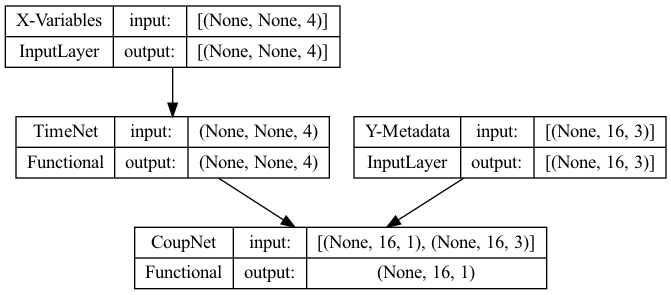

In [15]:
def make_dummy_timenet() -> keras.Model:
    x_Zvar = keras.Input(shape=(None, 4))
    y_Zvar = x_Zvar[:, -TARGET_LENGTH:]  # type: ignore

    return keras.Model(inputs=x_Zvar, outputs=y_Zvar, name="TimeNet")


def make_dummy_coupnet() -> keras.Model:
    y_Zvar = keras.Input(shape=(TARGET_LENGTH, 1), name="Y-ZVariable")
    y_meta = keras.Input(shape=(TARGET_LENGTH, METADATA_VARS), name="Y-Metadata")

    return keras.Model(inputs=[y_Zvar, y_meta], outputs=y_Zvar, name="CoupNet")


# make a dummy model whose output is the tail of the input sales values
dummy_model = make_model(
    timenet=make_dummy_timenet(), coupnet=make_dummy_coupnet(), name="DummyModel"
)

keras.utils.plot_model(
    dummy_model, show_shapes=True, to_file="_dummy.png", expand_nested=False
)

# TESTING THE MODELS

In [16]:
kdf = KeysDataFrame(TIMESTEPS, include_target=False)

In [40]:
EPOCHS = 2
SPLIT = 4

# NOTE sample keys not at random to ensure repeatability
# NOTE Take the keys spread across the entire range of stores and families
keys = kdf.keys[::10]

kds = KeysDataset(kdf, input_length=64, keys=keys)

In [31]:
def make_dense_timenet(input_length: int) -> keras.Model:
    name = "DENS-3x32"

    return keras.Sequential(
        [
            keras.Input(shape=(input_length, 4)),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Flatten(),
            keras.layers.Dense(TARGET_LENGTH),
            keras.layers.Reshape((TARGET_LENGTH, 1)),
        ],
        name=name + "-TimeNet",
    )

---

In [ ]:
model = make_model(make_dense_timenet(64), make_coupnet(), name="test")
model.compile(loss=LOSS, optimizer=keras.optimizers.Adam(learning_rate=1e-4))

hist = model.fit(
    kds.train.repeat(),
    validation_data=kds.valid,
    epochs=EPOCHS * SPLIT,
    steps_per_epoch=kds.length["train"] // SPLIT,
)

In [51]:
px.line(pl.DataFrame(hist.history), y=["loss", "val_loss"])

In [ ]:
# NOTE Try a model without the metadata

nmd_timenet = keras.Sequential(
    [
        keras.Input(shape=(64, 4)),
        keras.layers.Lambda(lambda xs: xs[:, :, 0, tf.newaxis]),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dense(TARGET_LENGTH),
        keras.layers.Reshape((TARGET_LENGTH, 1)),
    ],
    name="NoMetadata" + "-TimeNet",
)

model = make_model(nmd_timenet, make_coupnet(), "NoMetadata")

model.compile(loss=LOSS, optimizer=keras.optimizers.Adam(learning_rate=1e-4))

hist = model.fit(
    kds.train.repeat(),
    validation_data=kds.valid,
    epochs=EPOCHS * SPLIT,
    steps_per_epoch=kds.length["train"] // SPLIT,
)

In [35]:
px.line(pl.DataFrame(hist.history), y=["loss", "val_loss"])

In [ ]:
lstm_timenet = keras.Sequential(
    [
        keras.Input(shape=(None, 4)),
        keras.layers.LSTM(units=32, return_sequences=True),
        keras.layers.LSTM(units=32, return_sequences=True),
        keras.layers.LSTM(units=32, return_sequences=True),
        keras.layers.LSTM(units=TARGET_LENGTH, return_sequences=False),
        keras.layers.Reshape((TARGET_LENGTH, 1)),
    ]
)

lstm_model = make_model(lstm_timenet, make_coupnet(), name="lstm4")

lstm_model.compile(loss=LOSS, optimizer=keras.optimizers.Adam(learning_rate=1e-4))

hist = lstm_model.fit(
    kds.train.repeat(),
    validation_data=kds.valid,
    epochs=EPOCHS * SPLIT,
    steps_per_epoch=kds.length["train"] // SPLIT,
)

In [43]:
px.line(pl.DataFrame(hist.history), y=["loss", "val_loss"], log_y=True)

In [ ]:
lstm_timenet = keras.Sequential(
    [
        keras.Input(shape=(None, 4)),
        keras.layers.Lambda(lambda xs: xs[:, :, 0, tf.newaxis]),  # no metadata
        keras.layers.LSTM(units=32, return_sequences=True),
        keras.layers.LSTM(units=32, return_sequences=True),
        keras.layers.LSTM(units=32, return_sequences=True),
        keras.layers.LSTM(units=TARGET_LENGTH, return_sequences=False),
        keras.layers.Reshape((TARGET_LENGTH, 1)),
    ]
)

lstm_model = make_model(lstm_timenet, make_coupnet(), name="lstm1")

lstm_model.compile(loss=LOSS, optimizer=keras.optimizers.Adam(learning_rate=1e-4))

hist = lstm_model.fit(
    kds.train.repeat(),
    validation_data=kds.valid,
    epochs=EPOCHS * SPLIT,
    steps_per_epoch=kds.length["train"] // SPLIT,
)

In [45]:
px.line(pl.DataFrame(hist.history), y=["loss", "val_loss"], log_y=True)